# 0. GPU 확인

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1371719996257849041
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6267797504
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7507168192634641945
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

# 1. Create Dataset

In [2]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import glob
import random
from skimage.io import imread, imshow
from skimage.color import rgb2lab

## 1.1. data path

In [3]:
test_data_path = './data/test_data'
test_image_paths = glob.glob(os.path.join(test_data_path, '*'))
test_image_paths = sorted(test_image_paths)
test_image_paths

['./data/test_data\\DSCF1859.JPG',
 './data/test_data\\DSCF1880.JPG',
 './data/test_data\\ILSVRC2012_val_00000070.JPEG',
 './data/test_data\\ILSVRC2012_val_00000546.JPEG',
 './data/test_data\\ILSVRC2012_val_00000846.JPEG',
 './data/test_data\\ILSVRC2012_val_00000979.JPEG',
 './data/test_data\\ILSVRC2012_val_00001320.JPEG',
 './data/test_data\\ILSVRC2012_val_00001340.JPEG',
 './data/test_data\\ILSVRC2012_val_00002213.JPEG',
 './data/test_data\\ILSVRC2012_val_00002543.JPEG',
 './data/test_data\\ILSVRC2012_val_00003648.JPEG',
 './data/test_data\\ILSVRC2012_val_00003946.JPEG',
 './data/test_data\\ILSVRC2012_val_00004338.JPEG',
 './data/test_data\\ILSVRC2012_val_00004405.JPEG',
 './data/test_data\\ILSVRC2012_val_00004806.JPEG',
 './data/test_data\\ILSVRC2012_val_00004833.JPEG',
 './data/test_data\\ILSVRC2012_val_00005584.JPEG',
 './data/test_data\\ILSVRC2012_val_00006118.JPEG',
 './data/test_data\\ILSVRC2012_val_00006436.JPEG',
 './data/test_data\\ILSVRC2012_val_00006617.JPEG',
 './data/tes

## 1.2. Custom Dataset Class

In [4]:
class Custom_Image_Dataset(Dataset) :
    
    def __init__(self, image_paths, transforms=None):
        self.image_paths = image_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = imread(self.image_paths[idx])
        
        img_lab = rgb2lab(img)
        img_lab_norm = img_lab
        
        img_lab_norm[:, :, 0] = (img_lab_norm[:, :, 0]-50)/100
        img_lab_norm[:, :, 1] = img_lab_norm[:, :, 1]/110
        img_lab_norm[:, :, 2] = img_lab_norm[:, :, 2]/110
        
        img_l = np.expand_dims(img_lab_norm[:,:,0], axis = 2)
        img_ab = img_lab_norm[:, :, 1:]
        
        x = img_l
        y = img_ab
        
        if self.transforms is not None :
            x = self.transforms(x).float()
            y = self.transforms(y).float()
        
        return x, y

## 1.3. Data Load

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
test_dataset = Custom_Image_Dataset(test_image_paths, transform)
test_dataloader = DataLoader(test_dataset, batch_size = 4, shuffle = False)

# 2. Load Model

In [7]:
import torch
import torch.nn as nn

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2.1. define model function

In [9]:
class JKPSNET(nn.Module) :
    def __init__(self) :
        super().__init__()
        
        def conv_2xs(in_dim, out_dim) :
            model = nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_dim)
            )
            return model
        
        def conv_2x(in_dim, out_dim) :
            model = nn.Sequential(
                nn.Conv2d(in_dim, in_dim, kernel_size=3, stride=2, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_dim)
            )
            return model
        
        def conv_3xdil(dim) :
            model = nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(dim, dim, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(dim, dim, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(dim)
            )
            return model
        
        def conv_up(in_dim, out_dim) :
            model = nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_dim)
            )
            return model
        
        self.input = nn.Sequential()
        self.enc1 = conv_2xs(1, 64)
        self.enc2 = conv_2x(64, 128)
        self.enc3 = conv_2x(128, 256)
        self.enc4 = conv_2x(256, 512)
        self.convR = nn.Sequential(conv_3xdil(512))
       
        
        self.ups1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True)
        self.dec1 = conv_up(512, 256)
        self.ups2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=True)
        self.dec2 = conv_up(256, 128)
        self.ups3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=True)
        self.dec3 = conv_up(128, 64)

        self.abp = nn.Conv2d(64, 313, kernel_size=1, stride=1, padding=0, bias=True)
        self.softmax = nn.Softmax(dim=1)
        
        self.out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        
        self.print_cat = nn.Sequential()
        
        
        
    def forward(self, x):
        x = self.input(x)
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x = self.enc4(x3)
        x = self.convR(x)
        
        x = self.ups1(x)
        x = self.print_cat(torch.cat([x, x3], dim = 1))
        x = self.dec1(x)
        x = self.ups2(x)
        x = self.print_cat(torch.cat([x, x2], dim = 1))
        x = self.dec2(x)
        x = self.ups3(x)
        x = self.print_cat(torch.cat([x, x1], dim = 1))
        x = self.dec3(x)
        
        x = self.abp(x)
        
        x = self.out(self.softmax(x))
        
        
        return x

## 2.2. model compile

In [10]:
trained_model_JKPSNET = JKPSNET().to(device)

## 2.3. load trained state dict path

In [11]:
trained_state_dict_path = './data/model_saved/checkpoint_JKPSNET_LAB.pt'

## 2.3. load saved model 

In [12]:
trained_model_JKPSNET.load_state_dict(torch.load(trained_state_dict_path, map_location=device))

<All keys matched successfully>

# 3. Test

In [13]:
import numpy as np
from tqdm.notebook import tqdm

## 3.1. test function

In [14]:
def test_model(model, test_dataloader) :
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    test_data_list = []
    test_output_list = []
    test_target_list = []
    model.eval()
    
    test_dataloader_tqdm = tqdm(test_dataloader, desc="Test  ")
    for test_data, test_target in test_dataloader_tqdm :
        test_data = test_data.to(device)
        test_target = test_target.to(device)
        
        test_output = model(test_data)
        
        test_data_list.append(test_data.cpu().detach().numpy())
        test_output_list.append(test_output.cpu().detach().numpy())
        test_target_list.append(test_target.cpu().detach().numpy())
        
        del test_data
        del test_target
        del test_output
        torch.cuda.empty_cache()
    
    x = np.concatenate(test_data_list, axis = 0)
    y_predicted = np.concatenate(test_output_list, axis = 0)
    y_real = np.concatenate(test_target_list, axis = 0)
    
    torch.cuda.empty_cache()
    print("predict completed")
    
    return x, y_predicted, y_real

## 3.2. predict

In [15]:
x_test_L, y_test_predicted_AB, y_test_real_AB = test_model(trained_model_JKPSNET, test_dataloader)

Test  :   0%|          | 0/25 [00:00<?, ?it/s]

predict completed


In [16]:
y_test_predicted_AB.shape

(100, 2, 128, 128)

In [17]:
y_test_predicted_AB

array([[[[-2.20440445e-03, -1.96634955e-03, -1.58836693e-03, ...,
          -1.81553070e-03, -3.33608594e-03, -3.08679766e-03],
         [-1.20639370e-03,  3.26780282e-04,  1.25285925e-03, ...,
           1.72879698e-03,  1.37364073e-03, -1.02491106e-03],
         [-5.93349047e-04,  1.13186438e-03,  1.61698798e-03, ...,
           1.80574937e-03,  1.32451579e-03,  2.65209528e-04],
         ...,
         [-3.68502201e-03, -8.79670202e-04, -1.02998130e-03, ...,
          -2.36252602e-03,  1.25233212e-03, -2.57797248e-04],
         [-6.07760437e-03, -3.46362311e-03, -1.91737630e-03, ...,
          -1.51143514e-03,  7.51549844e-04, -1.87266851e-04],
         [-2.20037326e-02, -5.90683706e-03, -2.51713558e-03, ...,
          -3.32143973e-03, -1.76076114e-03, -1.99485524e-03]],

        [[ 1.17771002e-02,  3.91647918e-03,  2.61512236e-03, ...,
           2.45543220e-03,  4.46830178e-03,  1.07258512e-02],
         [ 7.03258952e-03,  4.29646950e-03,  5.55945653e-03, ...,
           5.66977309e

## 3.3. LAB De-Normalization and Conatenate 

In [18]:
def lab_concat_de_norm(L, AB) :

    l = L.copy()
    ab = AB.copy()
    l[:,0,:,:] = l[:,0,:,:]*100+50

    ab[:,0,:,:] = ab[:,0,:,:]*110
    ab[:,1,:,:] = ab[:,1,:,:]*110

    lab = np.concatenate((l, ab), axis = 1)    
    return lab

In [19]:
y_test_predicted_LAB = lab_concat_de_norm(x_test_L, y_test_predicted_AB)
y_test_real_LAB = lab_concat_de_norm(x_test_L, y_test_real_AB)

## 3.4. 채널 위치 변경 

In [20]:
print(y_test_predicted_LAB.shape)
print(y_test_real_LAB.shape)

(100, 3, 128, 128)
(100, 3, 128, 128)


In [21]:
y_test_predicted_LAB = y_test_predicted_LAB.swapaxes(1, 3).swapaxes(1, 2)
y_test_real_LAB = y_test_real_LAB.swapaxes(1, 3).swapaxes(1, 2)
print(y_test_predicted_LAB.shape)
print(y_test_real_LAB.shape)

(100, 128, 128, 3)
(100, 128, 128, 3)


## 3.5. LAB2RGB

In [22]:
from skimage.color import lab2rgb

In [23]:
def lab_2_rgb(y_test_LAB) :
    
    
    y_test_RGB = np.empty((0, 128, 128, 3), dtype=np.float32)
    for img_lab in y_test_LAB :
        img_rgb = lab2rgb(img_lab)
        img_rgb = np.expand_dims(img_rgb, axis = 0)
        y_test_RGB = np.append(y_test_RGB, img_rgb, axis=0)
    
    return y_test_RGB

In [24]:
y_test_predicted = lab_2_rgb(y_test_predicted_LAB)
y_test_real = lab_2_rgb(y_test_real_LAB)

## 3.6. X_test

In [25]:
x_test = x_test_L.copy()
x_test[:,0,:,:] = x_test[:,0,:,:]*100

# 4. Visualizing Test Result

## 4.1. test result visualizing function

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import minmax_scale
from tensorflow.keras import backend

In [27]:
def show_images(x, y_predicted, y_real, sn = 0):  

    x = x[:, 0, ...]
    
    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(10):

        ax = plt.subplot(3, n, i + 1)
        if x.ndim < 4:
            plt.imshow(x[i+sn], cmap='gray')
        else:
            plt.imshow(x[i+sn])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(y_predicted[i+sn])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(y_real[i+sn])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

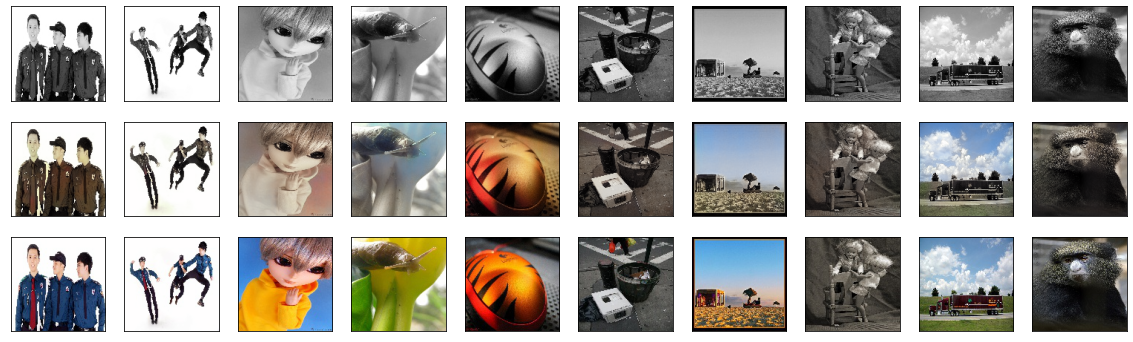

In [28]:
show_images(x_test, y_test_predicted, y_test_real)

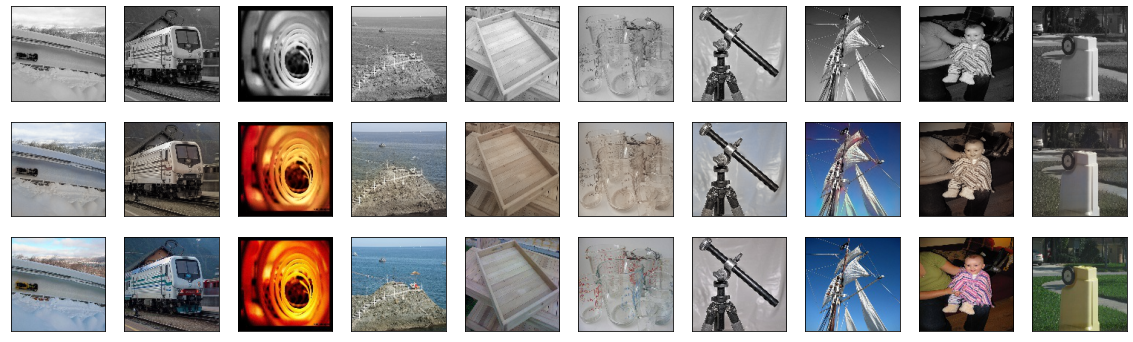

In [29]:
show_images(x_test, y_test_predicted, y_test_real, 10)

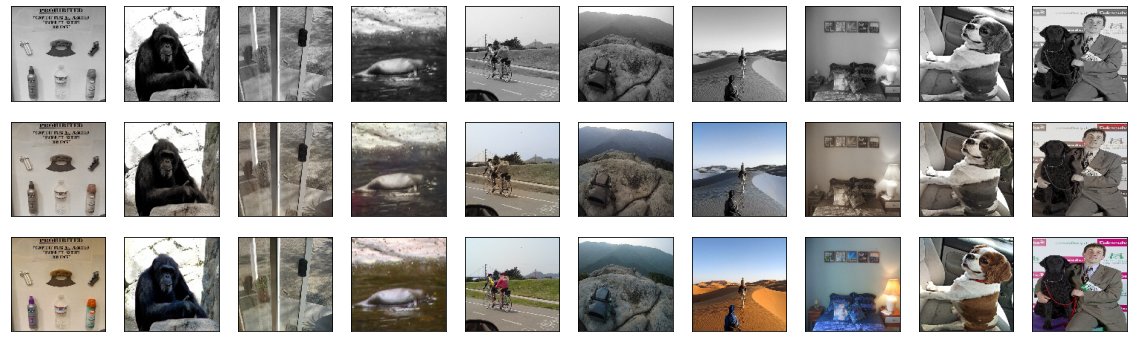

In [30]:
show_images(x_test, y_test_predicted, y_test_real, 20)

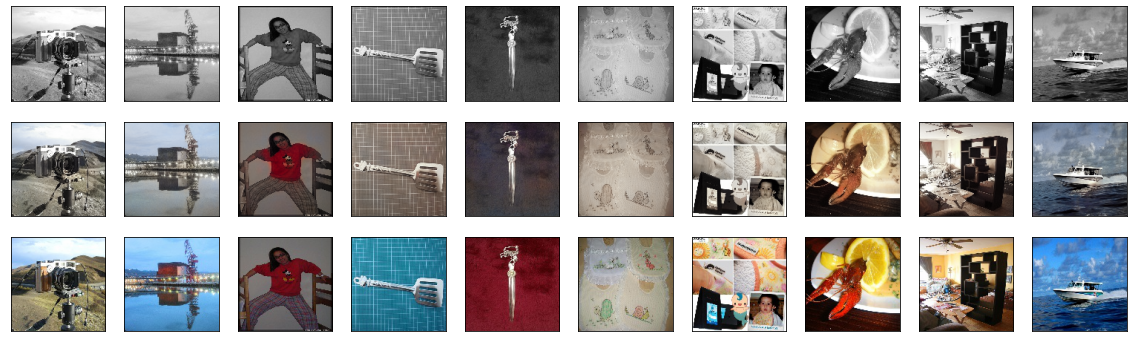

In [31]:
show_images(x_test, y_test_predicted, y_test_real, 30)

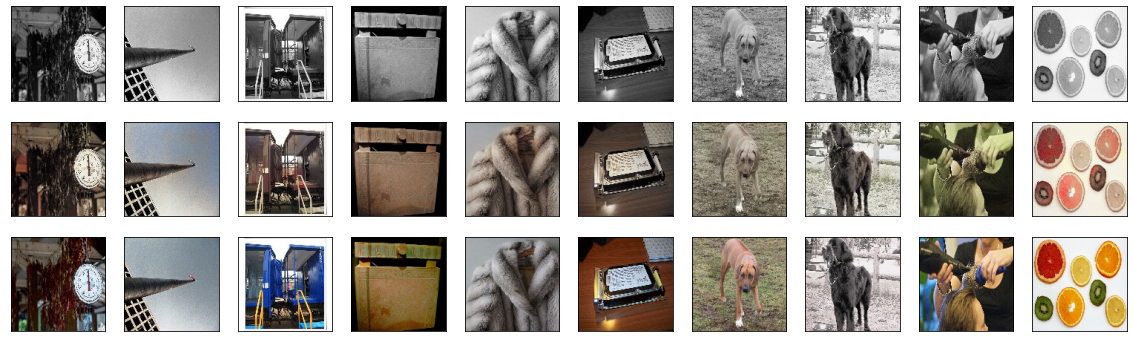

In [32]:
show_images(x_test, y_test_predicted, y_test_real, 40)

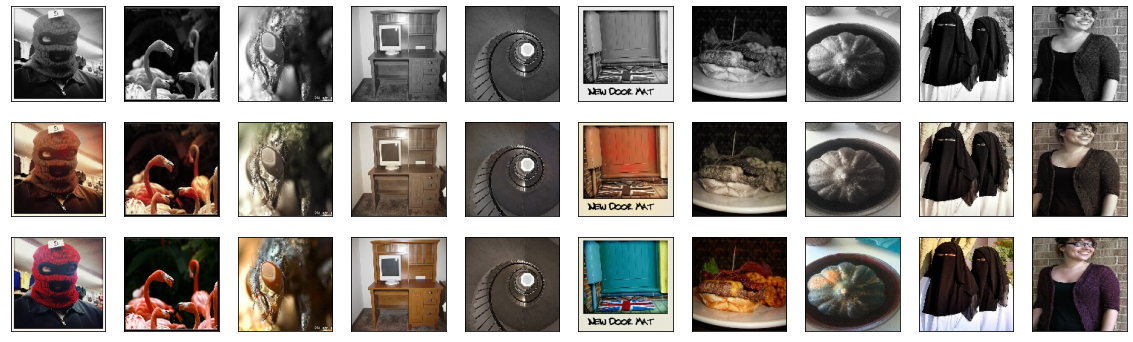

In [33]:
show_images(x_test, y_test_predicted, y_test_real, 50)

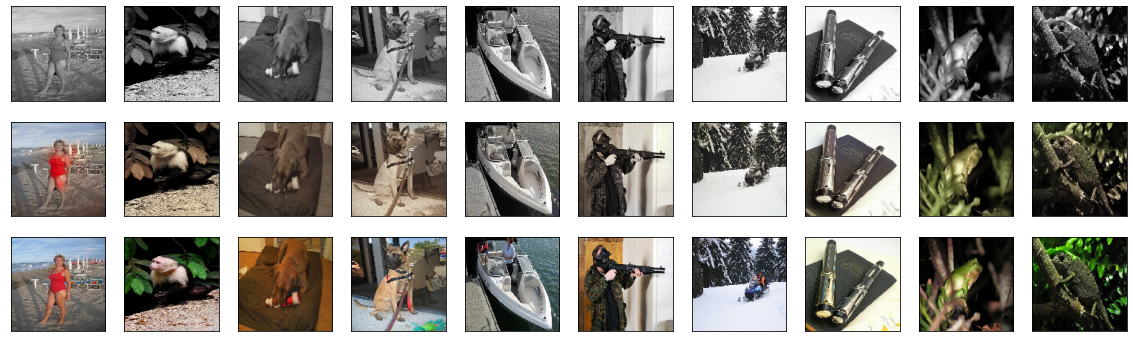

In [34]:
show_images(x_test, y_test_predicted, y_test_real, 60)

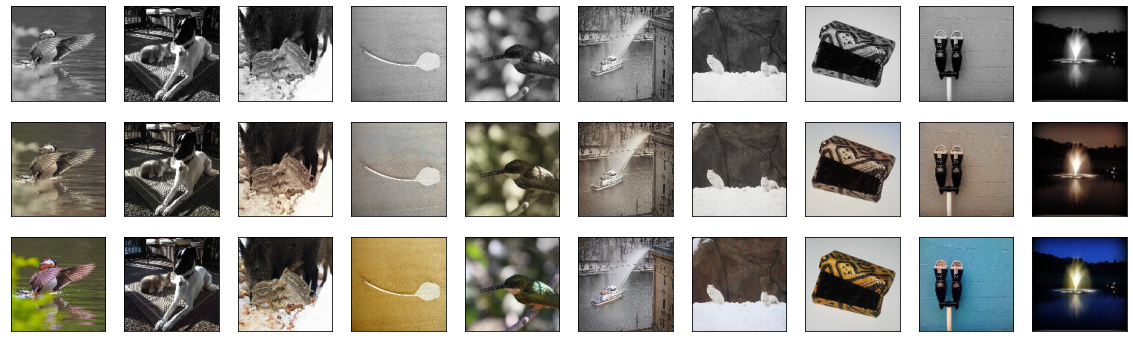

In [35]:
show_images(x_test, y_test_predicted, y_test_real, 70)

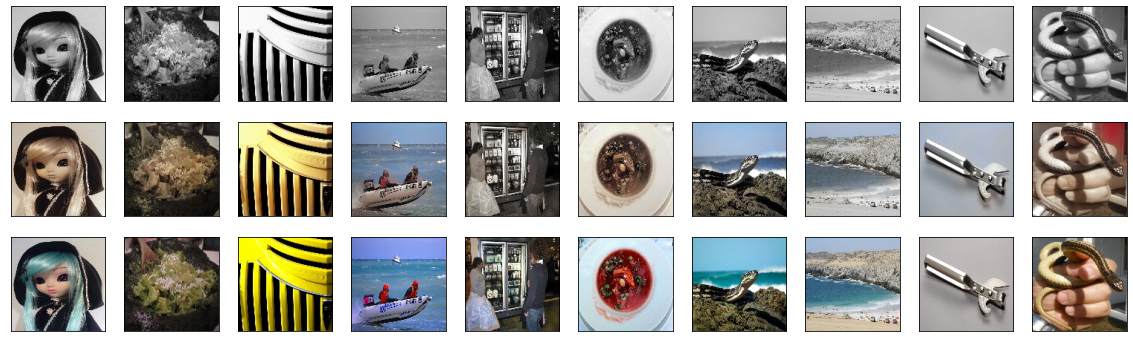

In [36]:
show_images(x_test, y_test_predicted, y_test_real, 80)

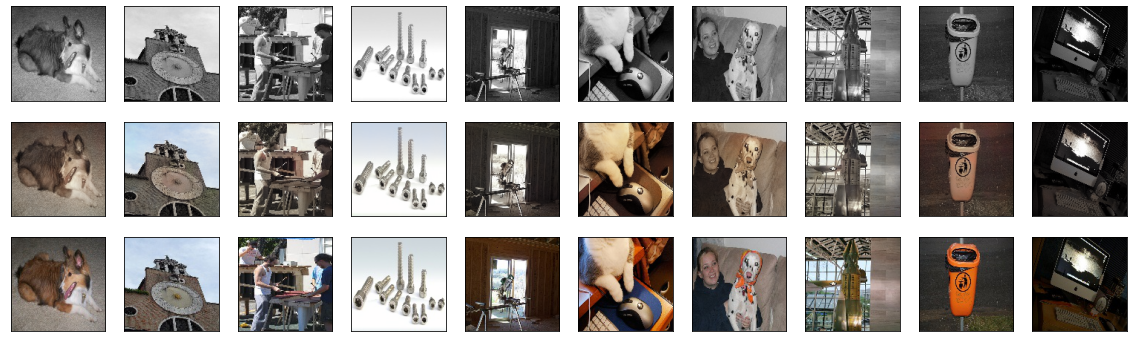

In [37]:
show_images(x_test, y_test_predicted, y_test_real, 90)